Определение мошенничества с кредитными картами
Набор данных: Credit Card Fraud Detection dataset на Kaggle.
https://habr.com/ru/companies/nix/articles/425907/ обучение чего то по разным моделям
https://habr.com/ru/articles/491552/ про автоэнкодеры
https://habr.com/ru/companies/nix/articles/478286/ про автоэнкодеры и несколько стандартных моделей на этом датасете 

In [46]:
import pandas as pd

creditcard_data = pd.read_csv("datasets/creditcard.csv")

creditcard_data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Маштабируем (столбцы Time и Amount)

In [48]:
from sklearn.preprocessing import RobustScaler

robust_scaler = RobustScaler()
creditcard_data["Amount"] = robust_scaler.fit_transform(creditcard_data["Amount"].values.reshape(-1, 1)) 
creditcard_data["Time"] = robust_scaler.fit_transform(creditcard_data["Time"].values.reshape(-1, 1))

x = creditcard_data.drop(columns='Class') 
y = creditcard_data['Class']

Разделяем на обучающую и тестовую выборки

Oversampling. Библиотекой увеличиваю количество случаев кардерства в датасете. Когда буду тестить нейронку это надо закомментировать.

Обучим модели: логистическую регрессию, SVM, случайный лес, градиентный бустинг

              precision    recall  f1-score   support

     Обычная       1.00      0.98      0.99     85296
      Кардер       0.06      0.90      0.12       147

    accuracy                           0.98     85443
   macro avg       0.53      0.94      0.55     85443
weighted avg       1.00      0.98      0.99     85443



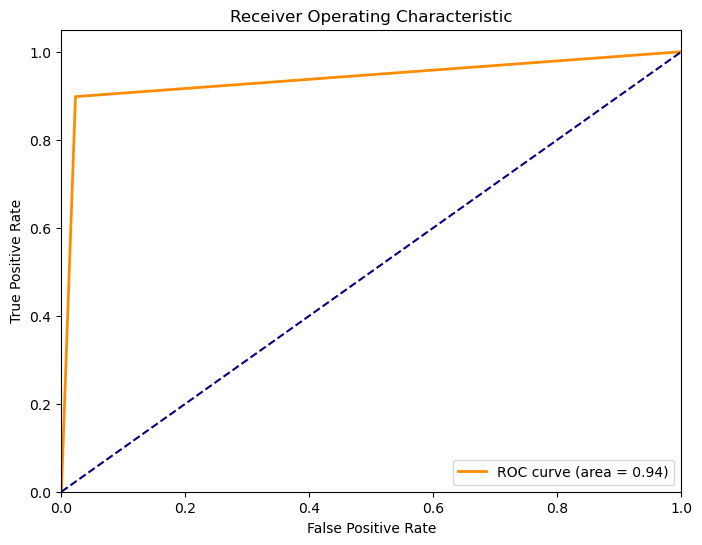

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3 ,random_state=50)

smote = SMOTE(random_state=42)
x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)

model = LogisticRegression(solver="liblinear", random_state=50)
model.fit(x_train_resampled, y_train_resampled)

y_pred = model.predict(x_test)
print(classification_report(y_test, y_pred, target_names=['Обычная', 'Кардер']))

fpr, tpr, _ = roc_curve(y_test,  y_pred)
auc = roc_auc_score(y_test, y_pred)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Высокая общая точность (accuracy): Accuracy 0.98 может ввести в заблуждение. Несмотря на кажущуюся высокую точность, модель плохо справляется с определением мошеннических транзакций (класс 1). Это происходит из-за сильного дисбаланса классов: обычных транзакций (класс 0) гораздо больше, чем мошеннических (класс 1).

Отличные результаты для обычных транзакций (класс 0): Precision и recall для класса 0 очень высокие, что говорит о том, что модель хорошо определяет обычные транзакции. Это ожидаемо, учитывая их преобладающее количество в наборе данных.

Проблемы с мошенническими транзакциями (класс 1):

Очень низкая precision: Precision для класса 1 составляет всего 0.06. Это означает, что из всех транзакций, которые модель пометила как мошеннические, только 6% действительно являются мошенническими. Модель генерирует много ложных срабатываний.

Высокий recall: Recall для класса 1 составляет 0.90. Это означает, что модель обнаруживает 90% всех мошеннических транзакций. Хотя это и хорошо, низкая точность делает модель практически бесполезной, так как приводит к большому количеству ложных срабатываний.

Низкий F1-score для класса 1: F1-score (0.12) является гармоническим средним precision и recall и показывает общий баланс между этими двумя метриками. Низкий F1-score для класса 1 подтверждает, что модель плохо справляется с определением мошеннических транзакций.

              precision    recall  f1-score   support

     Обычная       1.00      0.98      0.99     85296
      Кардер       0.08      0.90      0.14       147

    accuracy                           0.98     85443
   macro avg       0.54      0.94      0.57     85443
weighted avg       1.00      0.98      0.99     85443



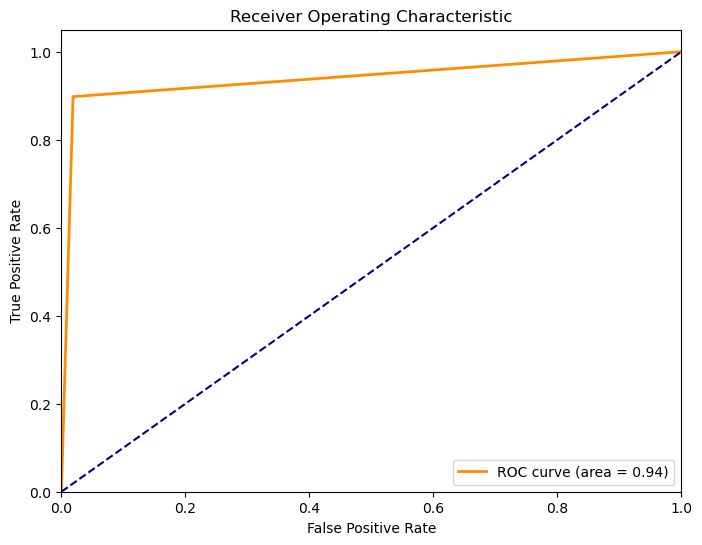

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3 ,random_state=50)

smote = SMOTE(random_state=42)
x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)

model2 = LinearSVC(random_state=50)
model2.fit(x_train_resampled, y_train_resampled)

y_pred = model2.predict(x_test)
print(classification_report(y_test, y_pred, target_names=['Обычная', 'Кардер']))

fpr, tpr, _ = roc_curve(y_test,  y_pred)
auc = roc_auc_score(y_test, y_pred)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Предсказание мошенничеств стало чуть чуть лучше но модель все еще переобучена на данных нормальных транзакций.
LinearSVC показывает небольшое улучшение в F1-score. Это гармоническое среднее precision и recall, и более высокое значение указывает на лучший баланс между точностью и полнотой.

              precision    recall  f1-score   support

     Обычная       1.00      1.00      1.00     85295
      Кардер       0.83      0.84      0.84       148

    accuracy                           1.00     85443
   macro avg       0.91      0.92      0.92     85443
weighted avg       1.00      1.00      1.00     85443



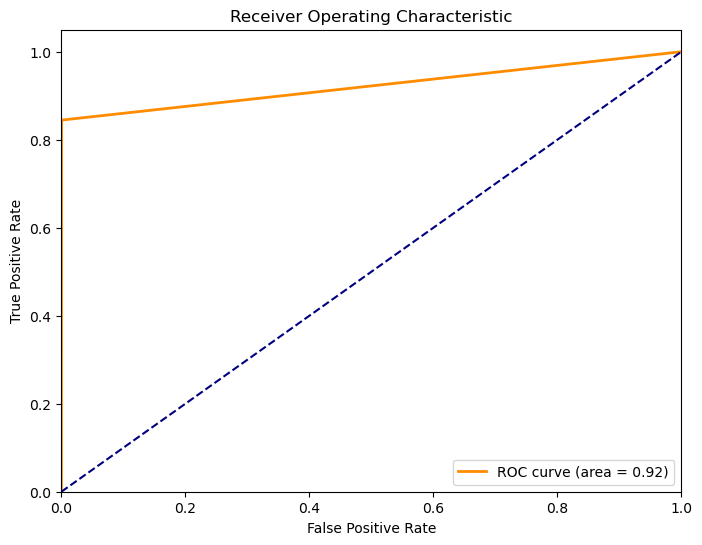

In [49]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=50, stratify=y)

smote = SMOTE(random_state=42)
x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)

model3 = RandomForestClassifier(n_estimators=30, max_depth=15, random_state=50)
model3.fit(x_train_resampled, y_train_resampled)

y_pred = model3.predict(x_test)
print(classification_report(y_test, y_pred, target_names=['Обычная', 'Кардер']))

fpr, tpr, _ = roc_curve(y_test,  y_pred)
auc = roc_auc_score(y_test, y_pred)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

удалось добиться хорошей точности и полноты с помощью рандомного леса. Возможно можно было еще повысить предсказание но время обучения стремительно расло поэтому остановилась на данном варианте

In [ ]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3 ,random_state=50, stratify=y)

smote = SMOTE(random_state=42)
x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)

model4 = HistGradientBoostingClassifier(max_depth=20, random_state=50)
model4.fit(x_train_resampled, y_train_resampled)

y_pred = model4.predict(x_test)
print(classification_report(y_test, y_pred,target_names=['Обычная', 'Кардер']))

fpr, tpr, _ = roc_curve(y_test,  y_pred)
auc = roc_auc_score(y_test, y_pred)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

              precision    recall  f1-score   support

     Обычная       1.00      1.00      1.00     85295
      Кардер       0.63      0.84      0.72       148

    accuracy                           1.00     85443
   macro avg       0.81      0.92      0.86     85443
weighted avg       1.00      1.00      1.00     85443



Следующий этап это обучение нейронки. Тут точно будет автоэнкодер и изолирующий лес. Данные буду разбивать с нуля потому что для автоэнкодера не надо увеличивать количество мошеннических транзакций. Отличие автоэнкодера от нейронки в том что я обучаю его только на нормальных транзакциях а мошенничества он будет считать выбросами.

готовим данные

In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

creditcard_data = pd.read_csv("datasets/creditcard.csv")

robust_scaler = RobustScaler()
creditcard_data["Amount"] = robust_scaler.fit_transform(creditcard_data["Amount"].values.reshape(-1, 1)) 
creditcard_data["Time"] = robust_scaler.fit_transform(creditcard_data["Time"].values.reshape(-1, 1))

normal_data = creditcard_data[creditcard_data['Class'] == 0]
crime_data = creditcard_data[creditcard_data['Class'] == 1]

x_normal = normal_data.drop(columns='Class', axis=1).values

x_train, x_test = train_test_split(x_normal, test_size=0.2, random_state=50)

автоэнкодер

In [22]:
from tensorflow import keras

encoding_neuro = 5
input_neuro = x_train.shape[1]

input_layer = keras.Input(shape=(input_neuro,))

encoder = keras.layers.Dense(16, activation="relu")(input_layer)
encoder = keras.layers.Dense(encoding_neuro, activation="relu")(encoder)

decoder = keras.layers.Dense(16, activation="relu")(encoder)
decoder = keras.layers.Dense(input_neuro, activation="sigmoid")(decoder)

autoencoder = keras.Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer="adam", loss="mse")

print(autoencoder.summary())

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 30)]              0         
                                                                 
 dense_8 (Dense)             (None, 16)                496       
                                                                 
 dense_9 (Dense)             (None, 5)                 85        
                                                                 
 dense_10 (Dense)            (None, 16)                96        
                                                                 
 dense_11 (Dense)            (None, 30)                510       
                                                                 
Total params: 1,187
Trainable params: 1,187
Non-trainable params: 0
_________________________________________________________________
None


In [23]:
epochs = 20
batch_size = 100
history = autoencoder.fit(x_train, x_train, epochs=epochs, batch_size=batch_size, shuffle=True, validation_data=(x_test, x_test))

x_test_full = creditcard_data.drop(columns='Class', axis=1).values
y_test_full = creditcard_data['Class'].values

predictions_test = autoencoder.predict(x_test_full)
mse_test = np.mean(np.power(x_test_full - predictions_test, 2), axis=1)

Epoch 1/20
2275/2275 [==============================] - 5s 2ms/step - loss: 1.2348 - val_loss: 1.3487
Epoch 2/20
2275/2275 [==============================] - 4s 2ms/step - loss: 1.1703 - val_loss: 1.3339
Epoch 3/20
2275/2275 [==============================] - 4s 2ms/step - loss: 1.1610 - val_loss: 1.3280
Epoch 4/20
2275/2275 [==============================] - 6s 2ms/step - loss: 1.1557 - val_loss: 1.3228
Epoch 5/20
2275/2275 [==============================] - 8s 4ms/step - loss: 1.1514 - val_loss: 1.3177
Epoch 6/20
2275/2275 [==============================] - 4s 2ms/step - loss: 1.1470 - val_loss: 1.3144
Epoch 7/20
2275/2275 [==============================] - 13s 6ms/step - loss: 1.1440 - val_loss: 1.3123
Epoch 8/20
2275/2275 [==============================] - 13s 6ms/step - loss: 1.1418 - val_loss: 1.3102
Epoch 9/20
2275/2275 [==============================] - 13s 6ms/step - loss: 1.1405 - val_loss: 1.3089
Epoch 10/20
2275/2275 [==============================] - 12s 5ms/step - loss: 1

              precision    recall  f1-score   support

      Normal       1.00      0.92      0.96    284315
       Fraud       0.02      0.89      0.04       492

    accuracy                           0.92    284807
   macro avg       0.51      0.90      0.50    284807
weighted avg       1.00      0.92      0.95    284807



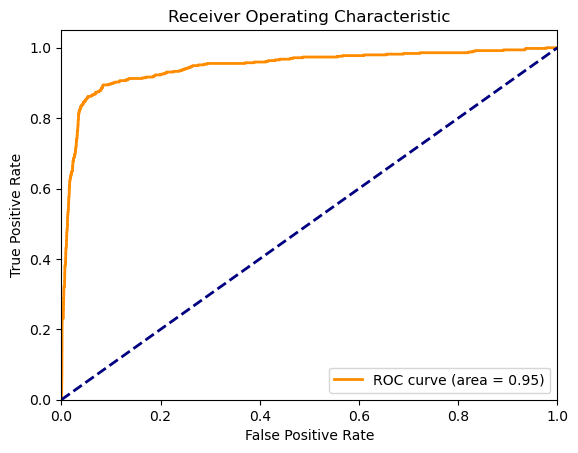

In [ ]:
from sklearn.metrics import classification_report, roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test_full, mse_test)
roc_auc = auc(fpr, tpr)

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

anomalies = (mse_test > optimal_threshold).astype(int)
print(classification_report(y_test_full, anomalies, target_names=['Normal', 'Fraud']))

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
      

не очень хорошее предсказание потому что автоэнкодеры больше подходят для определения а не предсказания. Дальше на данных с автоэнкодера обучу случайный лес. (Но до этого посмотрим как себя покажет изолирующий лес)

In [41]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

creditcard_data = pd.read_csv("datasets/creditcard.csv")

normal_data = creditcard_data[creditcard_data['Class'] == 0]
crime_data = creditcard_data[creditcard_data['Class'] == 1]

x_normal = normal_data.drop(columns='Class', axis=1).values

scaler = StandardScaler()
x_normal_scaled = scaler.fit_transform(x_normal)

x_train, x_test = train_test_split(x_normal_scaled, test_size=0.2, random_state=50)

              precision    recall  f1-score   support

     Обычная       1.00      1.00      1.00    284315
      Кардер       0.28      0.38      0.32       492

    accuracy                           1.00    284807
   macro avg       0.64      0.69      0.66    284807
weighted avg       1.00      1.00      1.00    284807



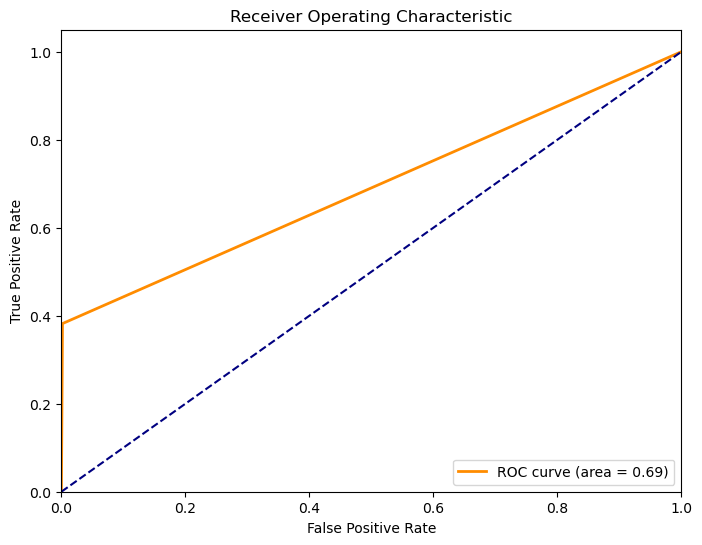

In [42]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

model5 = IsolationForest(n_estimators=100, contamination=float(len(crime_data)/len(normal_data)))
model5.fit(x_train)

x_test_full = creditcard_data.drop(columns='Class', axis=1).values
x_test_scaled_full = scaler.transform(x_test_full)
y_test_full = creditcard_data['Class'].values

y_pred = model5.predict(x_test_scaled_full)

y_pred[y_pred == 1] = 0
y_pred[y_pred == -1] = 1

print(classification_report(y_test_full, y_pred, target_names=['Обычная', 'Кардер']))

fpr, tpr, _ = roc_curve(y_test_full,  y_pred)
auc = roc_auc_score(y_test_full, y_pred)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [44]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from tensorflow import keras
from keras import layers
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_curve, roc_auc_score

creditcard_data = pd.read_csv("datasets/creditcard.csv")

robust_scaler = RobustScaler()
creditcard_data["Amount"] = robust_scaler.fit_transform(creditcard_data["Amount"].values.reshape(-1, 1))
creditcard_data["Time"] = robust_scaler.fit_transform(creditcard_data["Time"].values.reshape(-1, 1))

normal_data = creditcard_data[creditcard_data['Class'] == 0]
fraud_data = creditcard_data[creditcard_data['Class'] == 1]

X_normal = normal_data.drop(columns='Class', axis=1).values

X_train_normal, X_test_normal = train_test_split(X_normal, test_size=0.2, random_state=50)

input_dim = X_train_normal.shape[1]
encoding_dim = 10

input_layer = keras.Input(shape=(input_dim,))
encoder_layer = layers.Dense(encoding_dim, activation='relu')
encoder = encoder_layer(input_layer)

decoder_layer = layers.Dense(input_dim, activation='sigmoid') 
decoder = decoder_layer(encoder)

autoencoder = keras.Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.fit(X_train_normal, X_train_normal, epochs=20, batch_size=100, shuffle=True, validation_data=(X_test_normal, X_test_normal))

Epoch 1/20
2275/2275 [==============================] - 4s 2ms/step - loss: 1.2139 - val_loss: 1.3053
Epoch 2/20
2275/2275 [==============================] - 5s 2ms/step - loss: 1.1225 - val_loss: 1.2834
Epoch 3/20
2275/2275 [==============================] - 13s 6ms/step - loss: 1.1105 - val_loss: 1.2760
Epoch 4/20
2275/2275 [==============================] - 13s 6ms/step - loss: 1.1050 - val_loss: 1.2727
Epoch 5/20
2275/2275 [==============================] - 13s 6ms/step - loss: 1.1022 - val_loss: 1.2700
Epoch 6/20
2275/2275 [==============================] - 13s 6ms/step - loss: 1.0997 - val_loss: 1.2678
Epoch 7/20
2275/2275 [==============================] - 13s 6ms/step - loss: 1.0968 - val_loss: 1.2644
Epoch 8/20
2275/2275 [==============================] - 13s 6ms/step - loss: 1.0944 - val_loss: 1.2628
Epoch 9/20
2275/2275 [==============================] - 13s 6ms/step - loss: 1.0929 - val_loss: 1.2618
Epoch 10/20
2275/2275 [==============================] - 13s 6ms/step - los

1781/1781 [==============================] - 2s 957us/step
              precision    recall  f1-score   support

     Обычная       1.00      1.00      1.00     56874
      Кардер       0.97      0.68      0.80        88

    accuracy                           1.00     56962
   macro avg       0.98      0.84      0.90     56962
weighted avg       1.00      1.00      1.00     56962



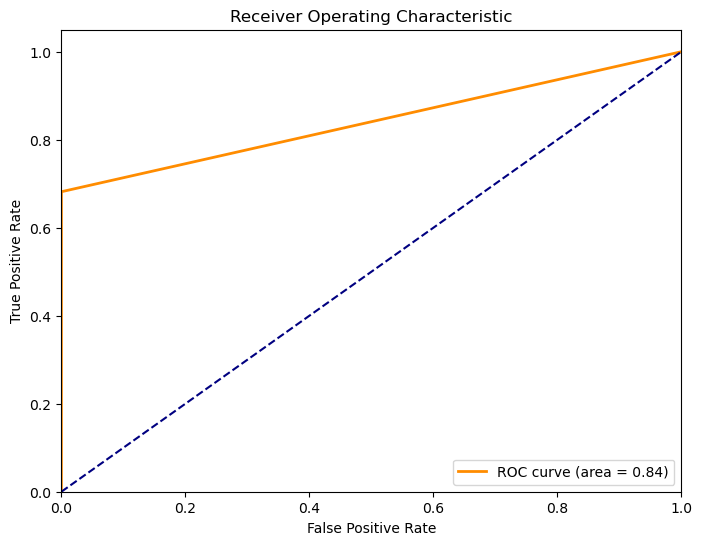

In [45]:
encoder_model = keras.Model(inputs=input_layer, outputs=encoder)

X = creditcard_data.drop(columns='Class', axis=1).values
y = creditcard_data['Class'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)

X_train_encoded = encoder_model.predict(X_train)
X_test_encoded = encoder_model.predict(X_test)

classifier = RandomForestClassifier(n_estimators=30)
classifier.fit(X_train_encoded, y_train)

y_pred = classifier.predict(X_test_encoded)
print(classification_report(y_test, y_pred, target_names=['Обычная', 'Кардер']))

fpr, tpr, _ = roc_curve(y_test,  y_pred)
auc = roc_auc_score(y_test, y_pred)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


ну вот тут видно что предсказание вышло очень хорошим но мы потеряли точность определения. Тоесть количество срабатываний больше чем реальных мошенничеств на 32%